In [1]:
import requests
import time
import random
import json
import re
from difflib import SequenceMatcher
from numpy.random import choice
import networkx as nx
from networkx.algorithms import bipartite
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from gensim.models import Word2Vec
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

from src.graph_embeddings.data_util import MalwareGraph

plt.rcParams['figure.figsize'] = [10, 10]

In [36]:
mg = MalwareGraph('../edge_lists/bin_dll_func.csv', 1000)

In [37]:
mg.get_vt_attributes('../VT_Scans2.json')

In [38]:
kas_dict, sym_dict, responses_with_labels, labeled_nodes = mg.get_scan_dict()

In [39]:
print(len(sym_dict), len(kas_dict))

229 229


In [40]:
numeric_node_feats = mg.compute_numeric_features(responses_with_labels, num_sections=10)

In [41]:
if len(mg.files) < 30:
    example_graph = nx.Graph()

    example_graph.add_nodes_from(mg.files)
    example_graph.add_nodes_from(mg.funcs)
    example_graph.add_nodes_from(mg.dlls)

    example_graph.add_edges_from(mg.file_dlls)
    example_graph.add_edges_from(mg.file_funcs)
    example_graph.add_edges_from(mg.func_dlls)
    pos=nx.spring_layout(example_graph)
    HSV = cm.get_cmap('viridis', 12)
    plt.rcParams['figure.figsize'] = [20, 20]
    nx.draw_networkx_nodes(mg.files, pos, node_color=HSV(0));
    nx.draw_networkx_nodes(mg.funcs, pos, node_color=HSV(4));
    nx.draw_networkx_nodes(mg.dlls, pos, node_color=HSV(6));

    nx.draw_networkx_edges(example_graph, pos);

In [42]:
vt_labels = []

indices1, indices2 = np.triu_indices(len(labeled_nodes), k=1, m=len(labeled_nodes))
node_comparison = np.zeros((len(labeled_nodes), len(labeled_nodes)))
for idx1, idx2 in zip(indices1, indices2):
    node1 = labeled_nodes[idx1]
    node2 = labeled_nodes[idx2]
    overlap1 = -1
    overlap2 = -1
    
    if kas_dict[node1] and kas_dict[node2]:
        node1_label = kas_dict[node1]
        node2_label = kas_dict[node2]   
        overlap1 = SequenceMatcher(None, node1_label, node2_label).ratio()
            
    if sym_dict[node1] and sym_dict[node2]:
        node1_label = sym_dict[node1]
        node2_label = sym_dict[node2]

        overlap2 = SequenceMatcher(None, node1_label, node2_label).ratio()
    
    if overlap1 == -1 and overlap2 == -1:
        node_comparison[idx1, idx2] = -1
        node_comparison[idx2, idx1] = -1
    elif overlap1 == -1:
        node_comparison[idx1, idx2] = overlap2 / 2
        node_comparison[idx2, idx1] = overlap2 / 2
    elif overlap2 == -1:
        node_comparison[idx1, idx2] = overlap1 / 2
        node_comparison[idx2, idx1] = overlap1 / 2
    else:
        node_comparison[idx1, idx2] = (overlap1 + overlap2) / 2
        node_comparison[idx2, idx1] = (overlap1 + overlap2) / 2
            

    if kas_dict[node1] or sym_dict[node1]:
        vt_labels.append((kas_dict[node1], sym_dict[node1]))

In [43]:
node_comparison = pd.DataFrame(node_comparison)
cluster_data = node_comparison.where(node_comparison >= 0).dropna(how='all').dropna(axis=1, how='all').fillna(0)
# cluster_data.to_csv('cluster_data.csv')

In [44]:
kmeans = KMeans(n_clusters=25)
kmeans.fit(cluster_data)

cluster_labels = kmeans.fit_predict(cluster_data)

In [45]:
class_color_map = {}
for node, lab in zip(labeled_nodes, cluster_labels):
    class_color_map[node] = lab

In [46]:
# Creat a graph just from labeled nodes

In [47]:
supervised = False
test_split = 0.01
val_split = 0.01

In [48]:
nodes_to_ids = {}
id_map = {}
class_map = {}
ids_to_nodes = {}
node_attr = {}

node_id = 0
for node in mg.files:
    if node not in nodes_to_ids and node in labeled_nodes:
        nodes_to_ids[node] = node_id
        id_map[str(node_id)] = node_id
        ids_to_nodes[node_id] = node
        rand = random.uniform(0, 1)
        if rand <= test_split:
            node_attr[node_id] = {'test': True, 'val': False}
        elif rand <= test_split + val_split:
            node_attr[node_id] = {'test': False, 'val': True}
        else:
            node_attr[node_id] = {'test': False, 'val': False}
        one_hot = np.zeros(max(cluster_labels))
        one_hot[class_color_map[node]-1] = 1 
        class_map[node_id] = list(one_hot)
        node_attr[node_id]['cluster'] = list(one_hot)
        if supervised:
            node_attr[node_id]['node_feats'] = list(numeric_node_feats[node])
        else:
            node_attr[node_id]['node_feats'] = list(numeric_node_feats[node]) + list(one_hot)
        
        node_id += 1

node_feats = np.array([node_attr[x]['node_feats'] for x in node_attr])
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(pd.DataFrame(node_feats))
node_feats = pd.DataFrame(x_scaled).values

In [49]:
arthrograph = nx.Graph()
arthrograph.add_nodes_from(labeled_nodes, bipartite=0)

labeled_funcs = []
labeled_edges = []
count = 0
for ff in mg.file_funcs:
    if ff[0] in labeled_nodes:
        labeled_funcs.append(ff[1])
        labeled_edges.append(ff)
    count += 1

arthrograph.add_nodes_from(labeled_funcs, bipartite=1)

arthrograph.add_edges_from(labeled_edges)

In [50]:
file_graph = bipartite.weighted_projected_graph(arthrograph, labeled_nodes, ratio=True)
arthrograph = None

In [51]:
labeled_file_graph = file_graph.subgraph(labeled_nodes)
file_graph = None
labeled_file_graph = nx.relabel_nodes(labeled_file_graph, nodes_to_ids)
nx.set_node_attributes(labeled_file_graph, node_attr)

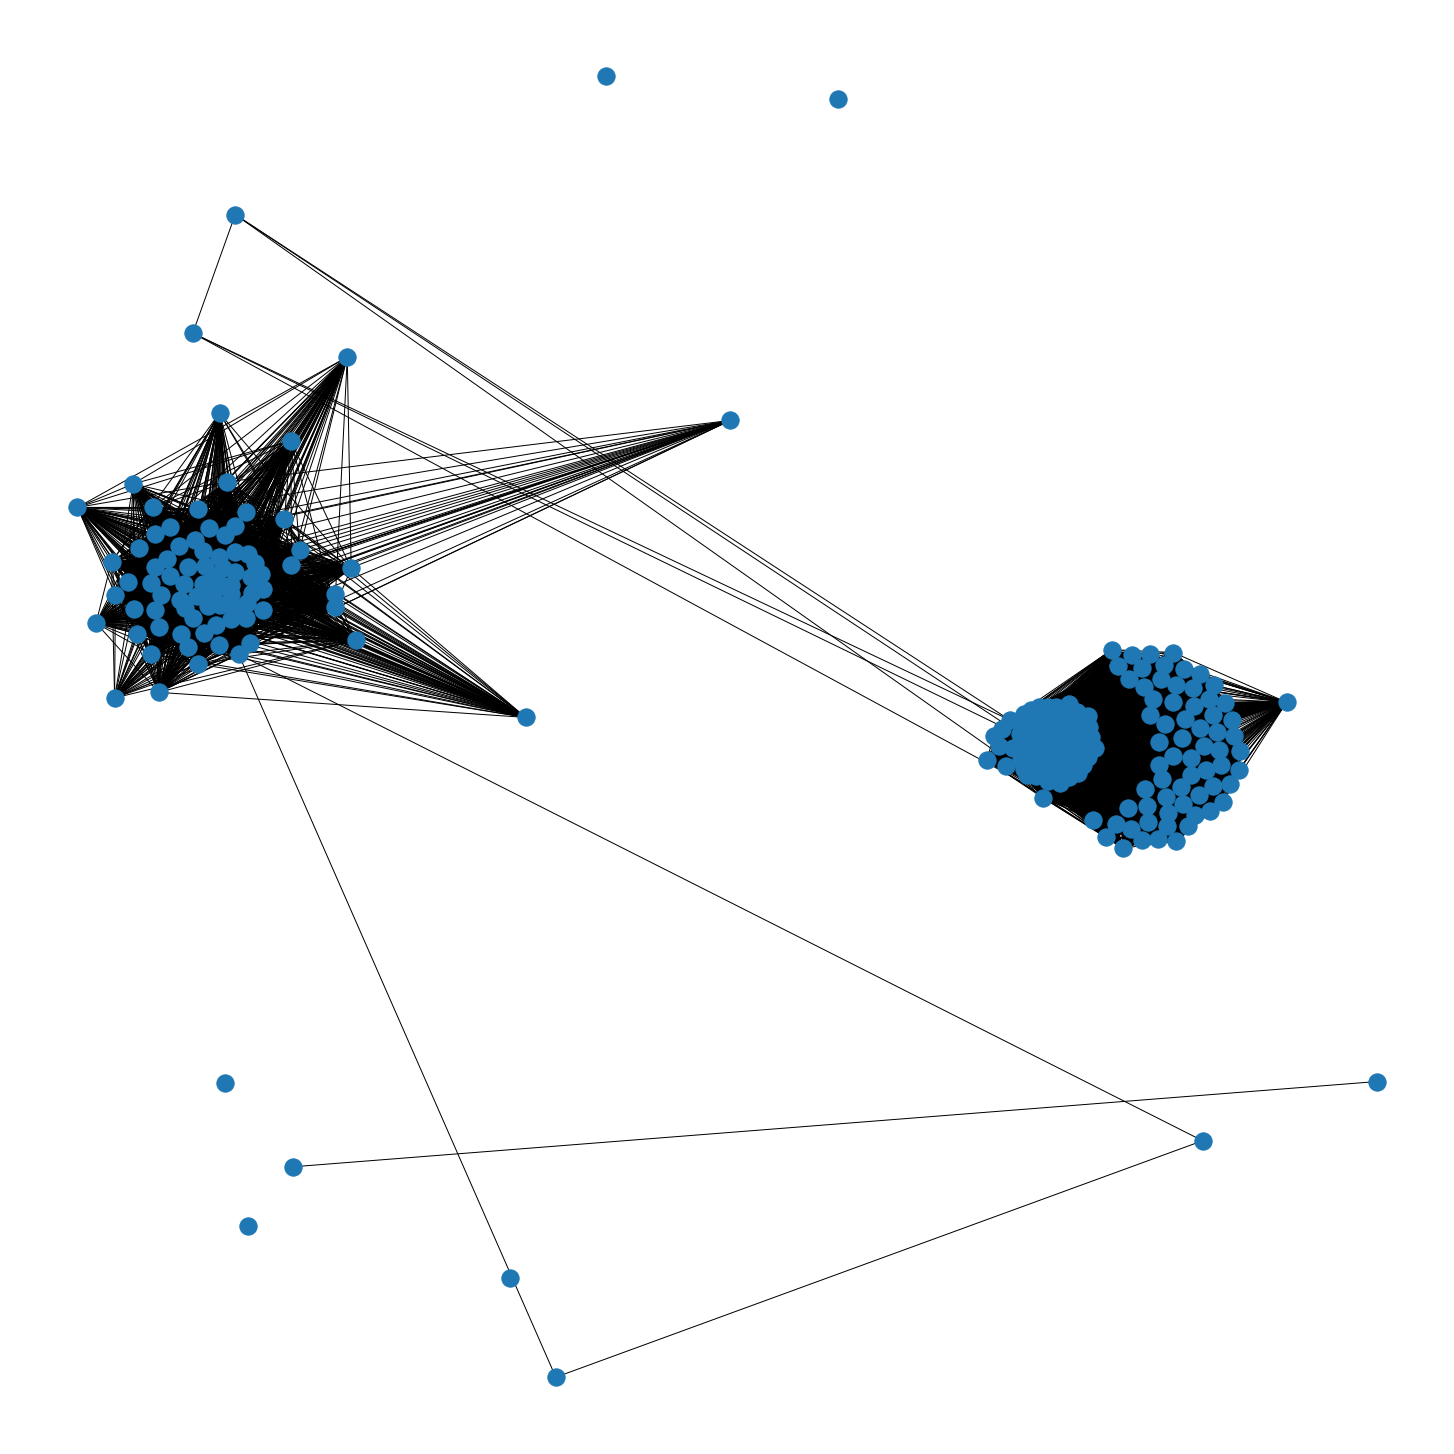

In [58]:
plt.rcParams['figure.figsize'] = [20, 20]
nx.draw(labeled_file_graph)

In [53]:
edge_attrs = {}
for edge in labeled_file_graph.edges():
    
    if node_attr[edge[0]]['test'] == True or node_attr[edge[1]]['test'] == True:
        edge_attrs[edge] = {'train_removed': True, 'test_removed': False}
        
    elif node_attr[edge[0]]['val'] == True or node_attr[edge[1]]['val'] == True:
        edge_attrs[edge] = {'train_removed': True, 'test_removed': True}
        
    else:
        edge_attrs[edge] = {'train_removed': False, 'test_removed': False}

nx.set_edge_attributes(labeled_file_graph, edge_attrs)

In [54]:
G_attr_matrix = nx.attr_matrix(labeled_file_graph, normalized=True)[0]

In [55]:
def choose_neighbor(G_attr_matrix, node):
    norm = G_attr_matrix[node][0].tolist()[0]
        
    if sum(norm) > 0.98:

        draw = choice(range(G_attr_matrix.shape[0]), 1, p=norm)[0]
    else:
        draw = node
    return draw

In [56]:
walks_per_node = 50
walk_length = 5
walks = []
pairs = []
for node in labeled_file_graph:
    st = time.time()
    node_walks = 0
    while node_walks < walks_per_node:
        walk = [node]
        cur_node = node
        while len(walk) < walk_length:
            next_node = choose_neighbor(G_attr_matrix, cur_node)
            walk.append(next_node)
            cur_node = next_node
            if cur_node != node:
                pairs.append((node, cur_node))
        walks.append(walk)
        node_walks += 1

In [57]:
with open('../../GraphSAGE/test_data/arthropod-G.json', 'w') as fp:
    json.dump(nx.node_link_data(labeled_file_graph), fp)

with open('../../GraphSAGE/test_data/arthropod-id_map.json', 'w') as fp:
    json.dump(id_map, fp)

with open('../../GraphSAGE/test_data/arthropod-class_map.json', 'w') as fp:
    json.dump(class_map, fp)

with open('../../GraphSAGE/test_data/arthropod-walks.txt', "w") as fp:
    fp.write("\n".join([str(p[0]) + "\t" + str(p[1]) for p in pairs]))

np.save('../../GraphSAGE/test_data/arthropod-feats.npy', node_feats)

In [270]:
graphsage_emb = np.load('../graphsage_embeddings/unsup-test_data/gcn_small_0.000010_wfeats_best/val.npy')
print(graphsage_emb.shape)
ids_to_rows = []
with open('../graphsage_embeddings/unsup-test_data/gcn_small_0.000010_wfeats_best/val.txt', "r") as fp:
    for line in fp.readlines():
        ids_to_rows.append(int(line.strip('\n')))
VT_scans = json.load(open('../VT_Scans.json'))
VT_scans_dict = {}
for scan in VT_scans:
    VT_scans_dict[scan['resource']] = scan
vocab = ids_to_rows
X = graphsage_emb

(4120, 256)


In [271]:
tsne = TSNE(n_components=2, perplexity=10, n_iter=5000)
X_tsne = tsne.fit_transform(X)
df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])

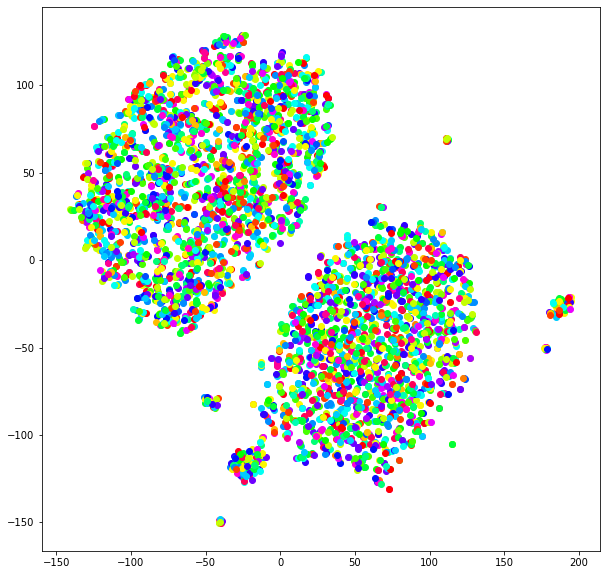

In [272]:
from matplotlib import cm
plt.rcParams['figure.figsize'] = [10, 10]

HSV = cm.get_cmap('hsv', 25)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)


for word, pos in df.iterrows():
    if ids_to_nodes[word] in mg.files:
        pt_color = HSV(class_color_map[ids_to_nodes[word]])
    ax.scatter(pos[0], pos[1], color=pt_color)

In [243]:
max(labeled_file_graph.nodes())

4420

In [266]:
correct = 0
val_count = 0

for idx, i in enumerate(np.matmul(X, X.T)):
    if node_attr[ids_to_rows[idx]]['val']:
        val_count+=1
        sims = [ids_to_rows[s] for s in i.argsort()[::-1][:11][1:]]
        real_neighbors = list(labeled_file_graph.neighbors(ids_to_rows[idx]))
        for n in sims:
            if n in real_neighbors:
                correct += 1
print(correct / (10 * val_count))

0.9125


In [169]:
degrees = []
for node in labeled_file_graph:
    degrees.append(len(list(labeled_file_graph.neighbors(node))))

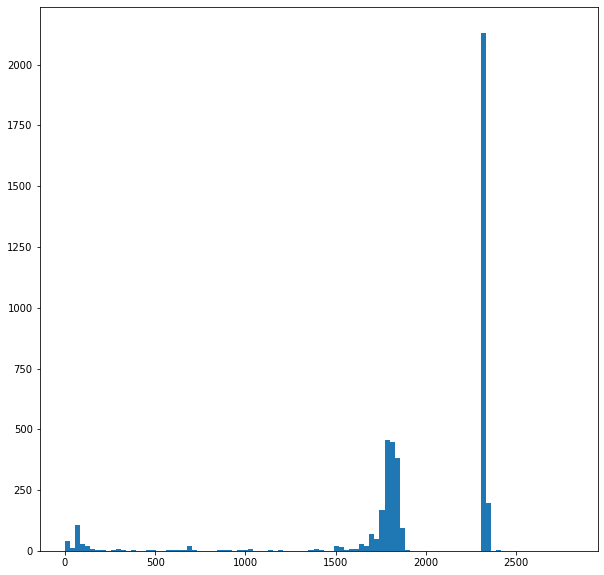

In [170]:
plt.hist(degrees, bins=100);

In [174]:
np.median(degrees)

2332.0